In [1]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
plt.rcParams['figure.facecolor'] = 'white'
import matplotlib.colors as colors
import cmocean.cm as cmo
from glob import glob

## Extraction at single points ("moorings") is still very slow for both methods, using xarray or using CDFTOOLS/NCO

In [2]:
moorx = [540, 820, 960, 650, 1040, 840, 870, 1200, 660, 540, 1080, 1070]
moory = [1530, 1250, 1150, 1220, 1320, 1540, 1660, 1000, 1550, 1620, 1460, 1400]
moorn = ["001", "002", "003", "004", "005", "006", "007", "008", "009", "WAL", "WLS", "WSZ"]

In [3]:
CONFS = ["CREG12.L75-REF08", "CREG12.L75-FUT08"]
years = {}
years[CONFS[0]] = [y for y in range(1996, 2016)]
years[CONFS[1]] = [y for y in range(2060, 2071)]

In [59]:
REFpath = "/data0/project/drakkar/USERS/jrieck/CREG12.L75-REF08-moorings"
moor1_REF = xr.open_mfdataset(sorted(glob(REFpath + "/*moor" + moorn[0] + "_I" + str(moorx[0]) + "J" + str(moory[0]) + "*.nc")), compat="override", coords="minimal")
moor2_REF = xr.open_mfdataset(sorted(glob(REFpath + "/*moor" + moorn[1] + "_I" + str(moorx[1]) + "J" + str(moory[1]) + "*.nc")), compat="override", coords="minimal")
moor3_REF = xr.open_mfdataset(sorted(glob(REFpath + "/*moor" + moorn[2] + "_I" + str(moorx[2]) + "J" + str(moory[2]) + "*.nc")), compat="override", coords="minimal")
moor4_REF = xr.open_mfdataset(sorted(glob(REFpath + "/*moor" + moorn[3] + "_I" + str(moorx[3]) + "J" + str(moory[3]) + "*.nc")), compat="override", coords="minimal")
moor5_REF = xr.open_mfdataset(sorted(glob(REFpath + "/*moor" + moorn[4] + "_I" + str(moorx[4]) + "J" + str(moory[4]) + "*.nc")), compat="override", coords="minimal")
moor6_REF = xr.open_mfdataset(sorted(glob(REFpath + "/*moor" + moorn[5] + "_I" + str(moorx[5]) + "J" + str(moory[5]) + "*.nc")), compat="override", coords="minimal")
moor7_REF = xr.open_mfdataset(sorted(glob(REFpath + "/*moor" + moorn[6] + "_I" + str(moorx[6]) + "J" + str(moory[6]) + "*.nc")), compat="override", coords="minimal")
moor8_REF = xr.open_mfdataset(sorted(glob(REFpath + "/*moor" + moorn[7] + "_I" + str(moorx[7]) + "J" + str(moory[7]) + "*.nc")), compat="override", coords="minimal")
moor9_REF = xr.open_mfdataset(sorted(glob(REFpath + "/*moor" + moorn[8] + "_I" + str(moorx[8]) + "J" + str(moory[8]) + "*.nc")), compat="override", coords="minimal")
moorWAL_REF = xr.open_mfdataset(sorted(glob(REFpath + "/*moor" + moorn[9] + "_I" + str(moorx[9]) + "J" + str(moory[9]) + "*.nc")), compat="override", coords="minimal")
moorWLS_REF = xr.open_mfdataset(sorted(glob(REFpath + "/*moor" + moorn[10] + "_I" + str(moorx[10]) + "J" + str(moory[10]) + "*.nc")), compat="override", coords="minimal")
moorWSZ_REF = xr.open_mfdataset(sorted(glob(REFpath + "/*moor" + moorn[11] + "_I" + str(moorx[11]) + "J" + str(moory[11]) + "*.nc")), compat="override", coords="minimal")

In [60]:
FUTpath = "/data0/project/drakkar/USERS/jrieck/CREG12.L75-FUT08-moorings"
moor1_FUT = xr.open_mfdataset(sorted(glob(FUTpath + "/*moor" + moorn[0] + "_I" + str(moorx[0]) + "J" + str(moory[0]) + "*.nc")), compat="override", coords="minimal")
moor2_FUT = xr.open_mfdataset(sorted(glob(FUTpath + "/*moor" + moorn[1] + "_I" + str(moorx[1]) + "J" + str(moory[1]) + "*.nc")), compat="override", coords="minimal")
moor3_FUT = xr.open_mfdataset(sorted(glob(FUTpath + "/*moor" + moorn[2] + "_I" + str(moorx[2]) + "J" + str(moory[2]) + "*.nc")), compat="override", coords="minimal")
moor4_FUT = xr.open_mfdataset(sorted(glob(FUTpath + "/*moor" + moorn[3] + "_I" + str(moorx[3]) + "J" + str(moory[3]) + "*.nc")), compat="override", coords="minimal")
moor5_FUT = xr.open_mfdataset(sorted(glob(FUTpath + "/*moor" + moorn[4] + "_I" + str(moorx[4]) + "J" + str(moory[4]) + "*.nc")), compat="override", coords="minimal")
moor6_FUT = xr.open_mfdataset(sorted(glob(FUTpath + "/*moor" + moorn[5] + "_I" + str(moorx[5]) + "J" + str(moory[5]) + "*.nc")), compat="override", coords="minimal")
moor7_FUT = xr.open_mfdataset(sorted(glob(FUTpath + "/*moor" + moorn[6] + "_I" + str(moorx[6]) + "J" + str(moory[6]) + "*.nc")), compat="override", coords="minimal")
moor8_FUT = xr.open_mfdataset(sorted(glob(FUTpath + "/*moor" + moorn[7] + "_I" + str(moorx[7]) + "J" + str(moory[7]) + "*.nc")), compat="override", coords="minimal")
moor9_FUT = xr.open_mfdataset(sorted(glob(FUTpath + "/*moor" + moorn[8] + "_I" + str(moorx[8]) + "J" + str(moory[8]) + "*.nc")), compat="override", coords="minimal")
moorWAL_FUT = xr.open_mfdataset(sorted(glob(FUTpath + "/*moor" + moorn[9] + "_I" + str(moorx[9]) + "J" + str(moory[9]) + "*.nc")), compat="override", coords="minimal")
moorWLS_FUT = xr.open_mfdataset(sorted(glob(FUTpath + "/*moor" + moorn[10] + "_I" + str(moorx[10]) + "J" + str(moory[10]) + "*.nc")), compat="override", coords="minimal")
moorWSZ_FUT = xr.open_mfdataset(sorted(glob(FUTpath + "/*moor" + moorn[11] + "_I" + str(moorx[11]) + "J" + str(moory[11]) + "*.nc")), compat="override", coords="minimal")

/home/rieck/.venv/py3_x/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home/rieck/.venv/py3_x/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home/rieck/.venv/py3_x/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home/rieck/.venv/py3_x/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home/rieck/.venv/py3_x/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home/rieck/.venv/py3_x/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home/rieck/.ven

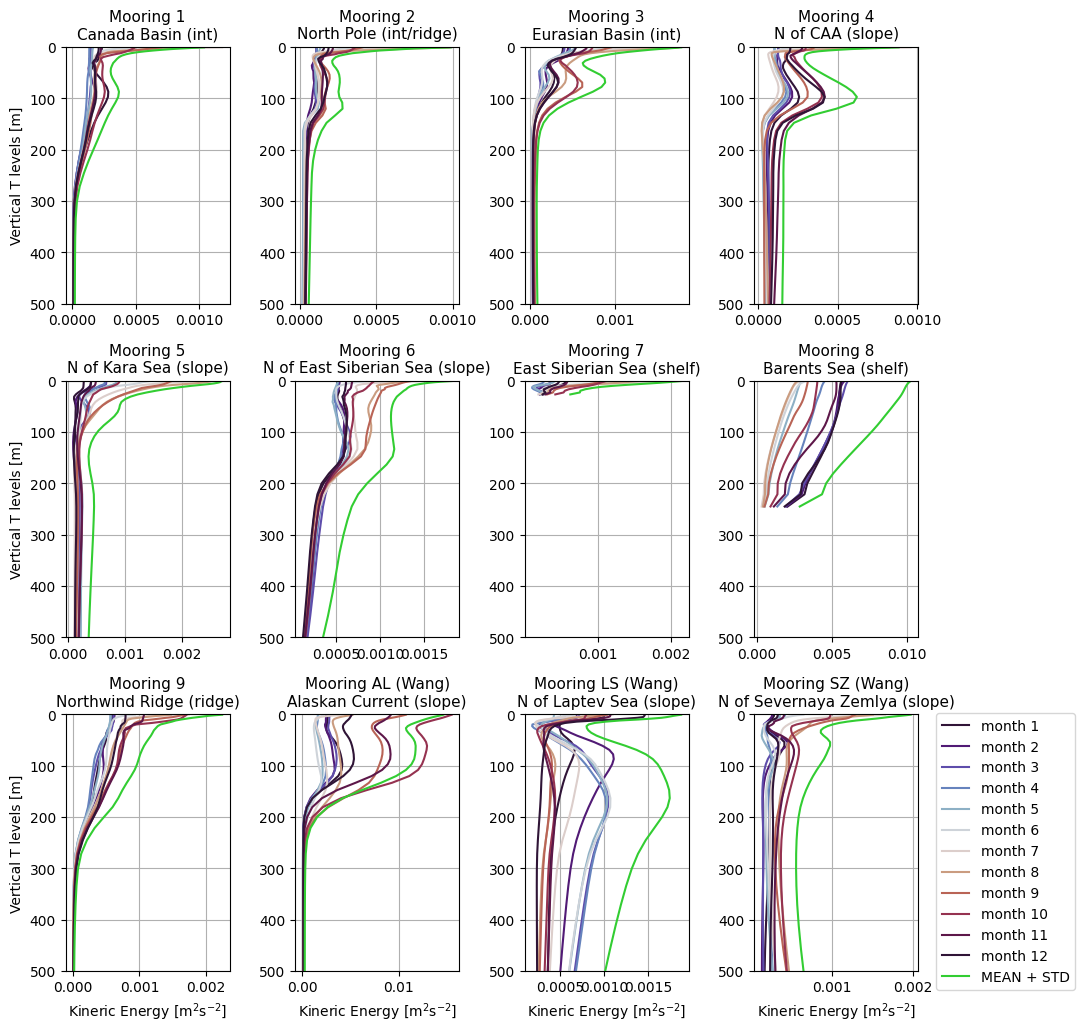

In [61]:
n = 12
REF_colors = plt.cm.twilight_shifted(np.linspace(0, 1, n))
max_depth = 40

fig, ax = plt.subplots(3, 4, figsize=(11, 12))
                 
for m in range(0, 12):
    moor1_REF.voke.groupby("time_counter.month").mean("time_counter").isel(deptht=slice(0, max_depth), month=m).plot(
        y="deptht", yincrease=False, color=REF_colors[m], label="month " + str(m+1), ax=ax[0, 0])
    moor2_REF.voke.groupby("time_counter.month").mean("time_counter").isel(deptht=slice(0, max_depth), month=m).plot(
        y="deptht", yincrease=False, color=REF_colors[m], label="month " + str(m+1), ax=ax[0, 1])
    moor3_REF.voke.groupby("time_counter.month").mean("time_counter").isel(deptht=slice(0, max_depth), month=m).plot(
        y="deptht", yincrease=False, color=REF_colors[m], label="month " + str(m+1), ax=ax[0, 2])
    moor4_REF.voke.groupby("time_counter.month").mean("time_counter").isel(deptht=slice(0, max_depth), month=m).plot(
        y="deptht", yincrease=False, color=REF_colors[m], label="month " + str(m+1), ax=ax[0, 3])
    moor5_REF.voke.groupby("time_counter.month").mean("time_counter").isel(deptht=slice(0, max_depth), month=m).plot(
        y="deptht", yincrease=False, color=REF_colors[m], label="month " + str(m+1), ax=ax[1, 0])
    moor6_REF.voke.groupby("time_counter.month").mean("time_counter").isel(deptht=slice(0, max_depth), month=m).plot(
        y="deptht", yincrease=False, color=REF_colors[m], label="month " + str(m+1), ax=ax[1, 1])
    moor7_REF.voke.groupby("time_counter.month").mean("time_counter").isel(deptht=slice(0, max_depth), month=m).plot(
        y="deptht", yincrease=False, color=REF_colors[m], label="month " + str(m+1), ax=ax[1, 2])
    moor8_REF.voke.groupby("time_counter.month").mean("time_counter").isel(deptht=slice(0, max_depth), month=m).plot(
        y="deptht", yincrease=False, color=REF_colors[m], label="month " + str(m+1), ax=ax[1, 3])
    moor9_REF.voke.groupby("time_counter.month").mean("time_counter").isel(deptht=slice(0, max_depth), month=m).plot(
        y="deptht", yincrease=False, color=REF_colors[m], label="month " + str(m+1), ax=ax[2, 0])
    moorWAL_REF.voke.groupby("time_counter.month").mean("time_counter").isel(deptht=slice(0, max_depth), month=m).plot(
        y="deptht", yincrease=False, color=REF_colors[m], label="month " + str(m+1), ax=ax[2, 1])
    moorWLS_REF.voke.groupby("time_counter.month").mean("time_counter").isel(deptht=slice(0, max_depth), month=m).plot(
        y="deptht", yincrease=False, color=REF_colors[m], label="month " + str(m+1), ax=ax[2, 2])
    moorWSZ_REF.voke.groupby("time_counter.month").mean("time_counter").isel(deptht=slice(0, max_depth), month=m).plot(
        y="deptht", yincrease=False, color=REF_colors[m], label="month " + str(m+1), ax=ax[2, 3])
(moor1_REF.voke.mean("time_counter") + moor1_REF.voke.std("time_counter")).isel(deptht=slice(0, max_depth)).plot(y="deptht", yincrease=False, 
                                                                                                               label="MEAN + STD", color="limegreen", ax=ax[0, 0])
(moor2_REF.voke.mean("time_counter") + moor2_REF.voke.std("time_counter")).isel(deptht=slice(0, max_depth)).plot(y="deptht", yincrease=False, 
                                                                                                               label="MEAN + STD", color="limegreen", ax=ax[0, 1])
(moor3_REF.voke.mean("time_counter") + moor3_REF.voke.std("time_counter")).isel(deptht=slice(0, max_depth)).plot(y="deptht", yincrease=False, 
                                                                                                               label="MEAN + STD", color="limegreen", ax=ax[0, 2])
(moor4_REF.voke.mean("time_counter") + moor4_REF.voke.std("time_counter")).isel(deptht=slice(0, max_depth)).plot(y="deptht", yincrease=False, 
                                                                                                               label="MEAN + STD", color="limegreen", ax=ax[0, 3])
(moor5_REF.voke.mean("time_counter") + moor5_REF.voke.std("time_counter")).isel(deptht=slice(0, max_depth)).plot(y="deptht", yincrease=False, 
                                                                                                               label="MEAN + STD", color="limegreen", ax=ax[1, 0])
(moor6_REF.voke.mean("time_counter") + moor6_REF.voke.std("time_counter")).isel(deptht=slice(0, max_depth)).plot(y="deptht", yincrease=False, 
                                                                                                               label="MEAN + STD", color="limegreen", ax=ax[1, 1])
(moor7_REF.voke.mean("time_counter") + moor7_REF.voke.std("time_counter")).isel(deptht=slice(0, max_depth)).plot(y="deptht", yincrease=False, 
                                                                                                               label="MEAN + STD", color="limegreen", ax=ax[1, 2])
(moor8_REF.voke.mean("time_counter") + moor8_REF.voke.std("time_counter")).isel(deptht=slice(0, max_depth)).plot(y="deptht", yincrease=False, 
                                                                                                               label="MEAN + STD", color="limegreen", ax=ax[1, 3])
(moor9_REF.voke.mean("time_counter") + moor9_REF.voke.std("time_counter")).isel(deptht=slice(0, max_depth)).plot(y="deptht", yincrease=False, 
                                                                                                               label="MEAN + STD", color="limegreen", ax=ax[2, 0])
(moorWAL_REF.voke.mean("time_counter") + moorWAL_REF.voke.std("time_counter")).isel(deptht=slice(0, max_depth)).plot(y="deptht", yincrease=False, 
                                                                                                               label="MEAN + STD", color="limegreen", ax=ax[2, 1])
(moorWLS_REF.voke.mean("time_counter") + moorWLS_REF.voke.std("time_counter")).isel(deptht=slice(0, max_depth)).plot(y="deptht", yincrease=False, 
                                                                                                               label="MEAN + STD", color="limegreen", ax=ax[2, 2])
(moorWSZ_REF.voke.mean("time_counter") + moorWSZ_REF.voke.std("time_counter")).isel(deptht=slice(0, max_depth)).plot(y="deptht", yincrease=False, 
                                                                                                               label="MEAN + STD", color="limegreen", ax=ax[2, 3])
ax[0, 0].set_title("Mooring 1\nCanada Basin (int)", fontsize=11)
ax[0, 1].set_title("Mooring 2\nNorth Pole (int/ridge)", fontsize=11)
ax[0, 2].set_title("Mooring 3\nEurasian Basin (int)", fontsize=11)
ax[0, 3].set_title("Mooring 4\nN of CAA (slope)", fontsize=11)
ax[1, 0].set_title("Mooring 5\nN of Kara Sea (slope)", fontsize=11)
ax[1, 1].set_title("Mooring 6\nN of East Siberian Sea (slope)", fontsize=11)
ax[1, 2].set_title("Mooring 7\nEast Siberian Sea (shelf)", fontsize=11)
ax[1, 3].set_title("Mooring 8\nBarents Sea (shelf)", fontsize=11)
ax[2, 0].set_title("Mooring 9\nNorthwind Ridge (ridge)", fontsize=11)
ax[2, 1].set_title("Mooring AL (Wang)\nAlaskan Current (slope)", fontsize=11)
ax[2, 2].set_title("Mooring LS (Wang)\nN of Laptev Sea (slope)", fontsize=11)
ax[2, 3].set_title("Mooring SZ (Wang)\nN of Severnaya Zemlya (slope)", fontsize=11)

for a in ax[0:2, :].flatten():
    a.set_xlabel("")
for a in ax[2, :].flatten():
    a.set_xlabel("Kineric Energy [m$^2$s$^{-2}$]")
for a in ax[:, 1:4].flatten():
    a.set_ylabel("")
for a in ax[:, :].flatten():
    a.grid()
    a.set_ylim(500, 0)

plt.legend(loc=4, bbox_to_anchor=(2., -0.1))
plt.subplots_adjust(hspace=0.3, wspace=0.4)

plt.savefig("../figures/CREG12.L75_KE_REF08_1996-2015_moorings_monthly_climatology.png", dpi=300)

/home/rieck/.venv/py3_x/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home/rieck/.venv/py3_x/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home/rieck/.venv/py3_x/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home/rieck/.venv/py3_x/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home/rieck/.venv/py3_x/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home/rieck/.venv/py3_x/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home/rieck/.ven

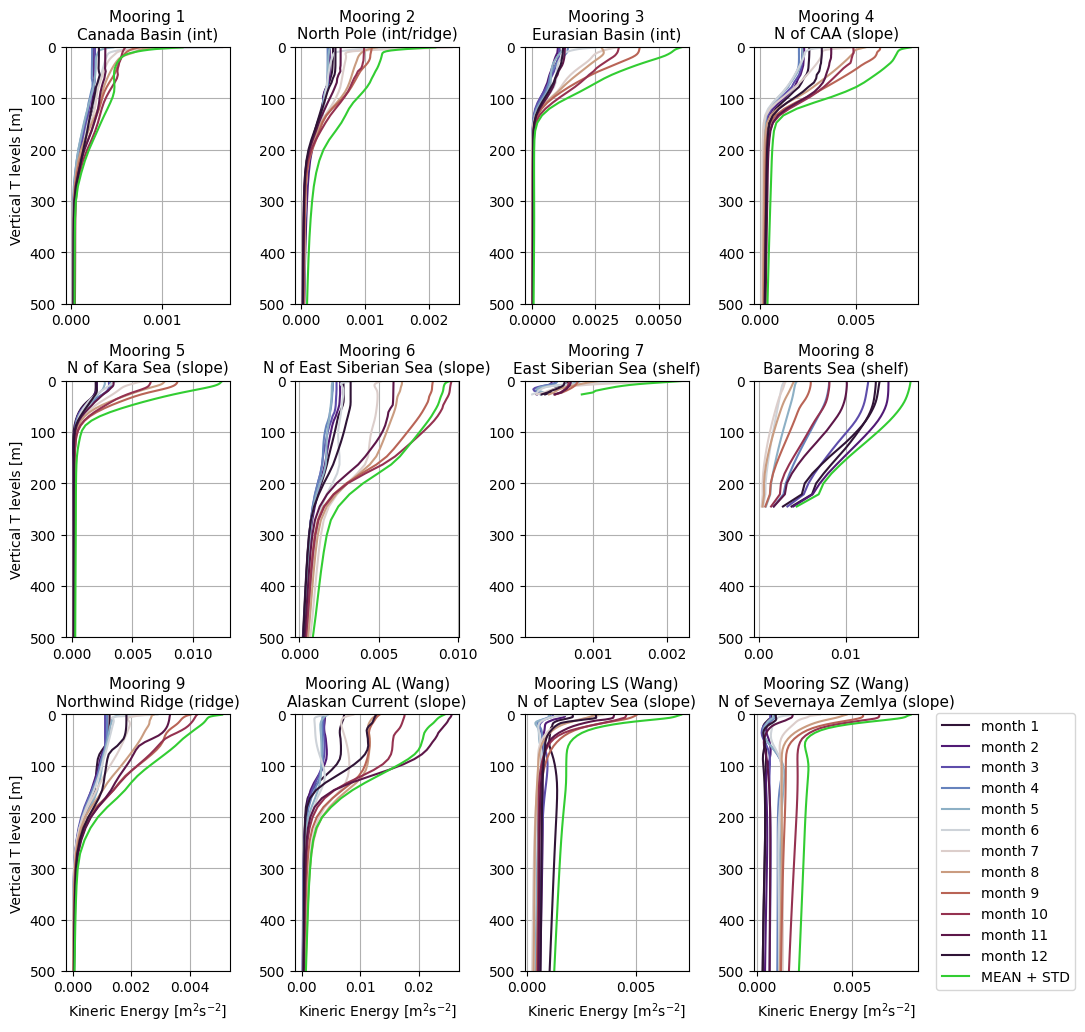

In [62]:
n = 12
REF_colors = plt.cm.twilight_shifted(np.linspace(0, 1, n))
max_depth = 40

fig, ax = plt.subplots(3, 4, figsize=(11, 12))
                 
for m in range(0, 12):
    moor1_FUT.voke.groupby("time_counter.month").mean("time_counter").isel(deptht=slice(0, max_depth), month=m).plot(
        y="deptht", yincrease=False, color=REF_colors[m], label="month " + str(m+1), ax=ax[0, 0])
    moor2_FUT.voke.groupby("time_counter.month").mean("time_counter").isel(deptht=slice(0, max_depth), month=m).plot(
        y="deptht", yincrease=False, color=REF_colors[m], label="month " + str(m+1), ax=ax[0, 1])
    moor3_FUT.voke.groupby("time_counter.month").mean("time_counter").isel(deptht=slice(0, max_depth), month=m).plot(
        y="deptht", yincrease=False, color=REF_colors[m], label="month " + str(m+1), ax=ax[0, 2])
    moor4_FUT.voke.groupby("time_counter.month").mean("time_counter").isel(deptht=slice(0, max_depth), month=m).plot(
        y="deptht", yincrease=False, color=REF_colors[m], label="month " + str(m+1), ax=ax[0, 3])
    moor5_FUT.voke.groupby("time_counter.month").mean("time_counter").isel(deptht=slice(0, max_depth), month=m).plot(
        y="deptht", yincrease=False, color=REF_colors[m], label="month " + str(m+1), ax=ax[1, 0])
    moor6_FUT.voke.groupby("time_counter.month").mean("time_counter").isel(deptht=slice(0, max_depth), month=m).plot(
        y="deptht", yincrease=False, color=REF_colors[m], label="month " + str(m+1), ax=ax[1, 1])
    moor7_FUT.voke.groupby("time_counter.month").mean("time_counter").isel(deptht=slice(0, max_depth), month=m).plot(
        y="deptht", yincrease=False, color=REF_colors[m], label="month " + str(m+1), ax=ax[1, 2])
    moor8_FUT.voke.groupby("time_counter.month").mean("time_counter").isel(deptht=slice(0, max_depth), month=m).plot(
        y="deptht", yincrease=False, color=REF_colors[m], label="month " + str(m+1), ax=ax[1, 3])
    moor9_FUT.voke.groupby("time_counter.month").mean("time_counter").isel(deptht=slice(0, max_depth), month=m).plot(
        y="deptht", yincrease=False, color=REF_colors[m], label="month " + str(m+1), ax=ax[2, 0])
    moorWAL_FUT.voke.groupby("time_counter.month").mean("time_counter").isel(deptht=slice(0, max_depth), month=m).plot(
        y="deptht", yincrease=False, color=REF_colors[m], label="month " + str(m+1), ax=ax[2, 1])
    moorWLS_FUT.voke.groupby("time_counter.month").mean("time_counter").isel(deptht=slice(0, max_depth), month=m).plot(
        y="deptht", yincrease=False, color=REF_colors[m], label="month " + str(m+1), ax=ax[2, 2])
    moorWSZ_FUT.voke.groupby("time_counter.month").mean("time_counter").isel(deptht=slice(0, max_depth), month=m).plot(
        y="deptht", yincrease=False, color=REF_colors[m], label="month " + str(m+1), ax=ax[2, 3])
(moor1_FUT.voke.mean("time_counter") + moor1_REF.voke.std("time_counter")).isel(deptht=slice(0, max_depth)).plot(y="deptht", yincrease=False, 
                                                                                                               label="MEAN + STD", color="limegreen", ax=ax[0, 0])
(moor2_FUT.voke.mean("time_counter") + moor2_FUT.voke.std("time_counter")).isel(deptht=slice(0, max_depth)).plot(y="deptht", yincrease=False, 
                                                                                                               label="MEAN + STD", color="limegreen", ax=ax[0, 1])
(moor3_FUT.voke.mean("time_counter") + moor3_FUT.voke.std("time_counter")).isel(deptht=slice(0, max_depth)).plot(y="deptht", yincrease=False, 
                                                                                                               label="MEAN + STD", color="limegreen", ax=ax[0, 2])
(moor4_FUT.voke.mean("time_counter") + moor4_FUT.voke.std("time_counter")).isel(deptht=slice(0, max_depth)).plot(y="deptht", yincrease=False, 
                                                                                                               label="MEAN + STD", color="limegreen", ax=ax[0, 3])
(moor5_FUT.voke.mean("time_counter") + moor5_FUT.voke.std("time_counter")).isel(deptht=slice(0, max_depth)).plot(y="deptht", yincrease=False, 
                                                                                                               label="MEAN + STD", color="limegreen", ax=ax[1, 0])
(moor6_FUT.voke.mean("time_counter") + moor6_FUT.voke.std("time_counter")).isel(deptht=slice(0, max_depth)).plot(y="deptht", yincrease=False, 
                                                                                                               label="MEAN + STD", color="limegreen", ax=ax[1, 1])
(moor7_FUT.voke.mean("time_counter") + moor7_FUT.voke.std("time_counter")).isel(deptht=slice(0, max_depth)).plot(y="deptht", yincrease=False, 
                                                                                                               label="MEAN + STD", color="limegreen", ax=ax[1, 2])
(moor8_FUT.voke.mean("time_counter") + moor8_FUT.voke.std("time_counter")).isel(deptht=slice(0, max_depth)).plot(y="deptht", yincrease=False, 
                                                                                                               label="MEAN + STD", color="limegreen", ax=ax[1, 3])
(moor9_FUT.voke.mean("time_counter") + moor9_FUT.voke.std("time_counter")).isel(deptht=slice(0, max_depth)).plot(y="deptht", yincrease=False, 
                                                                                                               label="MEAN + STD", color="limegreen", ax=ax[2, 0])
(moorWAL_FUT.voke.mean("time_counter") + moorWAL_FUT.voke.std("time_counter")).isel(deptht=slice(0, max_depth)).plot(y="deptht", yincrease=False, 
                                                                                                               label="MEAN + STD", color="limegreen", ax=ax[2, 1])
(moorWLS_FUT.voke.mean("time_counter") + moorWLS_FUT.voke.std("time_counter")).isel(deptht=slice(0, max_depth)).plot(y="deptht", yincrease=False, 
                                                                                                               label="MEAN + STD", color="limegreen", ax=ax[2, 2])
(moorWSZ_FUT.voke.mean("time_counter") + moorWSZ_FUT.voke.std("time_counter")).isel(deptht=slice(0, max_depth)).plot(y="deptht", yincrease=False, 
                                                                                                               label="MEAN + STD", color="limegreen", ax=ax[2, 3])
ax[0, 0].set_title("Mooring 1\nCanada Basin (int)", fontsize=11)
ax[0, 1].set_title("Mooring 2\nNorth Pole (int/ridge)", fontsize=11)
ax[0, 2].set_title("Mooring 3\nEurasian Basin (int)", fontsize=11)
ax[0, 3].set_title("Mooring 4\nN of CAA (slope)", fontsize=11)
ax[1, 0].set_title("Mooring 5\nN of Kara Sea (slope)", fontsize=11)
ax[1, 1].set_title("Mooring 6\nN of East Siberian Sea (slope)", fontsize=11)
ax[1, 2].set_title("Mooring 7\nEast Siberian Sea (shelf)", fontsize=11)
ax[1, 3].set_title("Mooring 8\nBarents Sea (shelf)", fontsize=11)
ax[2, 0].set_title("Mooring 9\nNorthwind Ridge (ridge)", fontsize=11)
ax[2, 1].set_title("Mooring AL (Wang)\nAlaskan Current (slope)", fontsize=11)
ax[2, 2].set_title("Mooring LS (Wang)\nN of Laptev Sea (slope)", fontsize=11)
ax[2, 3].set_title("Mooring SZ (Wang)\nN of Severnaya Zemlya (slope)", fontsize=11)

for a in ax[0:2, :].flatten():
    a.set_xlabel("")
for a in ax[2, :].flatten():
    a.set_xlabel("Kineric Energy [m$^2$s$^{-2}$]")
for a in ax[:, 1:4].flatten():
    a.set_ylabel("")
for a in ax[:, :].flatten():
    a.grid()
    a.set_ylim(500, 0)

plt.legend(loc=4, bbox_to_anchor=(2., -0.1))
plt.subplots_adjust(hspace=0.3, wspace=0.4)

plt.savefig("../figures/CREG12.L75_KE_FUT08_2051-2070_moorings_monthly_climatology.png", dpi=300)

. Canada Basin (1) and North Pole (2) are very similar -> we keep Canada Basin (1) and Eurasian Basin (3) as interior locations